This notebook describes how to compute and derive insights from various classification evaluation metrics.

- **Model evaluation** is an important part of a training process since it ensures that a model has been properly trained on the existing dataset and can be used to make predictions for an unseen dataset.

- There are a number of metrics such as accuracy, precision, recall, f1-score that are commonly used to evaluate a model. They are calculated based on the number of correct and incorrect predictions broken down by each class.  



The dataset used in this notebook was downloaded from https://archive.ics.uci.edu/ml/index.php. The dataset contains four numerical predictors, and the target is a binary variable that indicates whether or not a person donated blood (1 and 0). To stay focused on the evaluation metrics topic, I did not apply any EDA to the data. If you are interested, please use the link to download the data and run your EDA and data preprocessing.

In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv('metrics_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Donated    748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [2]:
df['Donated'].value_counts()

0    570
1    178
Name: Donated, dtype: int64

In [3]:
# tranforming three skewed features
df['Recency']=df['Recency']+1
for col in ['Recency', 'Frequency','Monetary']:
    df[col]= np.log2(df[col])

In [4]:
# creates predictors and target datasets
X= df.drop('Donated', axis=1)
y=df['Donated']

### Classification
A logistic regression classifier was used to predict whether or not a person would donate blood. Please note that default parameters were used without tuning any hyper-parameters in order to stay focused on the metrics topic.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
# split the data into training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, stratify=y, random_state=103)

In [7]:
# scale the predictor features based on the training data 
scaler=StandardScaler()
scaler.fit(X_train)

X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [8]:
# fits the model
lri=LogisticRegression()
lri.fit(X_train, y_train)

LogisticRegression()

- There are a number of metrics such as accuracy, precision, recall, f1-score that are commonly used to evaluate a model. They are calculated based on the number of correct and incorrect predictions broken down by each class that are usually represented by a confusion matrix.  

### 1) Confusion matrix
- A confusion matrixthe represents the number of correct and incorrect predictions broken down by each class.

In [9]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, lri.predict(X_test))

array([[163,   8],
       [ 40,  14]], dtype=int64)

**Note**: Values extracted from the confusion matrix: TP=14, FP=8, TN=163, FN=40
- The number of class 0 samples is greater than the number of class 1 samples, resulting in an imbalance. In a separate notebook, I discussed dealing with imbalanced datasets, and you can find out about techniques that are used for creating a balanced dataset.
 

In this case, I attempted to create a training dataset with an equal number of samples for each class using an oversampling method.

In [10]:
from imblearn.combine import SMOTETomek

In [11]:
# oversampling the data
smt = SMOTETomek(sampling_strategy='auto')
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

In [12]:
# fit the model to new datasets
lr=LogisticRegression()

lr.fit(X_train_smt, y_train_smt)

LogisticRegression()

In [13]:
confusion_matrix(y_test, lr.predict(X_test))

array([[122,  49],
       [ 16,  38]], dtype=int64)

**Insight:** Using a balanced dataset to train the model improved model performance for class 1.


### 2) Accuracy
- Although a confusion matrix can provide useful information, looking at and digesting all of the numbers presented in the matrix can sometimes be overwhelming. Confusion matrices can be summarized into a single value metric such as accuracy, recall, or precision.

- Accuracy is defined as the ratio of the number of correctly classified samples to the total number of samples. For a training task, a model accuracy is represented by a single value (unlike other parameters such as precision, recall, and f1-score that are reported for each class using 1 vs. all methodology).

$$Accuracy=TP/(TP+FP+TN+FN)$$

In [14]:
from sklearn.metrics import accuracy_score

print ('Accuracy (imbalanced dataset): {:2.2%}'.format(accuracy_score(y_test, lri.predict(X_test))))
print ('Accuracy (balanced dataset): {:2.2%}'.format(accuracy_score(y_test, lr.predict(X_test))))

Accuracy (imbalanced dataset): 78.67%
Accuracy (balanced dataset): 71.11%


- Accuracy may become a misleading and ineffective metric in the case of an imbalanced dataset in which the number of samples belonging to one class is significantly greater than the others.

- The first model that was trained on the imbalanced dataset performed poorly on class 1; however, the model accuracy is higher due to the large number of true negative samples.

### 3) Recall
- Recall is the proprtion of samples in a class that are correctly predicted.

- If the target class is important in your analysis and you do not want any of the target samples to be classified as non-target class, recall is the metric to focus on as a high recall rate relates to a low false negative rate.
$$Recall=TP/(TP+FN)$$

In [15]:
from sklearn.metrics import recall_score

print ('Recall: {:2.2%}'.format(recall_score(y_test, lr.predict(X_test))))

Recall: 70.37%


**insight:** A high recall value shows that the model correctly predicted the majority of those who donated blood. 

###  4) Precision
- Precision is defined by the ratio of predicted positive samples being actually positive. 

- If you don't want a large number of non-target class samples to be classified as target class, precision could be the primary metric for your analysis as high precision relates to a low false positive rate.
$$Precision=TP/(TP+FP)$$

In [16]:
from sklearn.metrics import precision_score

In [17]:
print ('Precision: {:2.2%}'.format(precision_score(y_test, lr.predict(X_test))))

Precision: 43.68%


**Insight:** A low precision value indicates that many samples from class 0 (those who did not donate) are classified as class 1.

### 5) f1 score
- Precision and recall can be combined and represented as the f1-score, which is the harmonic average of their values. Both false positive and false negative values are considered to calculate this metric.

In [18]:
from sklearn.metrics import f1_score

In [19]:
print ('f1_score: {:2.2}'.format(f1_score(y_test, lr.predict(X_test))))

f1_score: 0.54


### 6) Precision-recall curve
- There is a trade-off between precision and recall, which means that altering the probability threshold (used to determine the predicted class) increases one parameter while decreasing the other.

- The **precision-recall curve** depicts the trade-off between precision and recall. A large area under the curve indicates that the model has a high recall as well as a high precision.

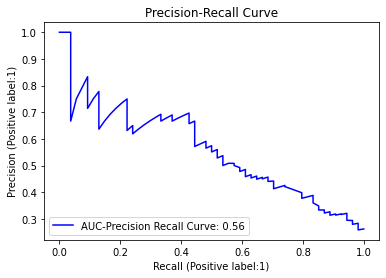

In [20]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, lr.predict_proba(X_test)[:,1])

auc_rp = auc(recall, precision)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue', label="AUC-Precision Recall Curve: {:.2}".format(auc_rp))

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision (Positive label:1)')
ax.set_xlabel('Recall (Positive label:1)')
plt.legend(loc="lower left")
plt.show()

**Insight:** The precision-recall curve shows how quickly precision drops with the slight increase in recall value. As the probality threshold is reduced to allow more samples from class 1 to be predicted as class 1, a large number of samples of class 0 that are also predicted as class 1 (False positive). 
The low auc value, as well as the shape of the graph indicate that the trained model is underfitted (bias issue) and must be re-built.  

### 7) AUC-ROC score
- The AUC-ROC score, which is calculated using the area under the Receiver Operating Characteristics curve, is one of the most reliable metrics for evaluating a classifier.


- The ROC curve is a graphical representation of a classifier's ability to distinguish between classes at different probability thresholds.


- True Positive rate (which is equivalent to recall: TP/TP+FN) is plotted against False Positive rate (FP/FP+TN) at different probability thresholds to generate a ROC graph.


- The ideal case is for the TP rate to remain high while the FP rate decreases as the threshold rises, resulting in a high AUC value. Using the one vs aLL methodology, we can plot the n number of AUC ROC Curves for n number of classes in a multi-class model.

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score

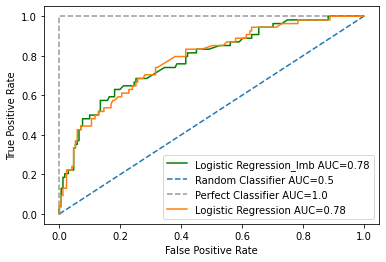

In [22]:
# fpr: false positive rate, tpr=true positive rate
auc_lr = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

fpr, tpr, _ = roc_curve(y_test,  lr.predict_proba(X_test)[:,1])

# random classifier. A classifier with no skill. Only predicts 0 for all samples
random_probs = [0 for _ in range(len(y_test))]
auc_random = roc_auc_score(y_test, random_probs)
rn_fpr, rn_tpr, _ = roc_curve(y_test, random_probs)

# classifier trained on imbalanced dataset
auc_lri = roc_auc_score(y_test, lri.predict_proba(X_test)[:,1])

i_fpr, i_tpr, _ = roc_curve(y_test,  lri.predict_proba(X_test)[:,1])

# perfect classifier. predicting all samples correctly
auc_perfect = roc_auc_score(y_test, y_test)
pr_fpr, pr_tpr, _ = roc_curve(y_test, y_test)


#create ROC curve
plt.plot(i_fpr,i_tpr,label="Logistic Regression_Imb AUC={:.2}".format(auc_lri), color='green')
plt.plot(rn_fpr, rn_tpr, linestyle='--', label='Random Classifier AUC={:.2}'.format(auc_random))
plt.plot(pr_fpr, pr_tpr, linestyle='--',color='black', alpha=0.4, label='Perfect Classifier AUC={:.2}'.format(auc_perfect))
plt.plot(fpr,tpr,label="Logistic Regression AUC={:.2}".format(auc_lr))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

- This plot can be used to compare the performance of a model to distinguish a class, the performance of different classifiers (to choose the best performer), or to track the performance of a classifier over time to ensure its performance has not deteriorated and to determine if retraining or remodelling is required. 
- It can also be used to select a suitable threshold value (rather than the default 0.5) in order to achieve the desired TP and FP values.

**Insight:** 
- The auc value for the model is relatively high, but it is far from a well-trained model.

- The graphs for two models (trained with balanced and imbalanced datasets) are similar in shape and auc values, indicating that creating a balanced dataset had no significant impact on model performance, and it still suffers from underfitting. Creating new features from existing predictors may aid in improving model performance.